In [1]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

print("Running...")
toc = time.perf_counter()
#ALL SETUP

thr_std=0.2
n_events=9310


E = Events("CheatedRecoFile_1.root")


view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")


u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x


v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x

tic = time.perf_counter()
print("All data loaded in", tic-toc, "seconds")

Running...
All data loaded in 289.3447867 seconds


In [3]:
def AoI(plane, event_number, thresholding=True, no_std=thr_std, ordering=True):
    #given plane and event number, extract required information and threshold if required
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
        
    if ordering:
        order = np.argsort(AoI_z)
        AoI_z = np.take_along_axis(AoI_z, order, axis=0)
        AoI_x = np.take_along_axis(AoI_x, order, axis=0)
        AoI_adc = np.take_along_axis(AoI_adc, order, axis=0)
        
    AoI = [AoI_z, AoI_x, AoI_adc]
    return AoI, (AoI_truevtxz,AoI_truevtxx)
#AoI, true = AoI("u", 657)
AoI, true = AoI("u", 20)

In [4]:
print(AoI)

[array([1417.6783, 1418.145 , 1418.6117, 1419.0785, 1419.5452, 1420.0118,
       1420.4785, 1420.9452, 1421.412 , 1421.8787, 1422.3453, 1422.812 ,
       1423.2787, 1423.7455, 1424.2122, 1424.6788, 1425.1455, 1425.6122,
       1426.079 , 1426.5457, 1427.0123, 1427.479 , 1427.9457, 1428.4125,
       1428.8792, 1429.3458, 1429.8125, 1430.2793, 1430.746 , 1431.2126,
       1431.6793, 1432.146 , 1432.6128, 1433.0795, 1433.5461, 1434.0128,
       1434.4795], dtype=float32), array([-106.992   , -105.74131 , -104.664185, -103.47235 , -102.286316,
       -101.16882 ,  -99.95044 ,  -98.7236  ,  -97.507256,  -96.22531 ,
        -94.957726,  -93.80997 ,  -92.694084,  -91.461296,  -90.30634 ,
        -89.12383 ,  -87.87997 ,  -86.680756,  -85.43956 ,  -84.24875 ,
        -83.03447 ,  -81.814766,  -80.51614 ,  -79.16324 ,  -77.751175,
        -76.3055  ,  -74.816864,  -73.208405,  -71.52228 ,  -69.84746 ,
        -68.08853 ,  -66.52391 ,  -65.02387 ,  -63.51062 ,  -61.967422,
        -60.537872,  -

0

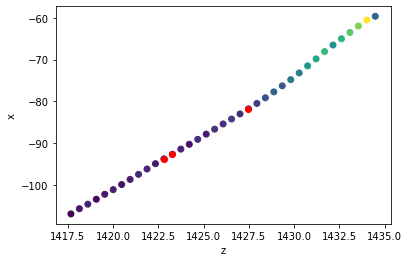

In [6]:
def plotter(AoI, thresholding=True, no_std=thr_std):
    
    AoIz, AoIx, AoIadc = AoI
    
    plt.scatter(AoIz, AoIx, c=AoIadc, cmap="viridis")
    plt.plot(AoIz[12], AoIx[12], 'ro')
    plt.plot(AoIz[11], AoIx[11], 'ro')
    plt.plot(AoIz[21], AoIx[21], 'ro')
    #plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")
    return 0
plotter(AoI)


In [7]:
def line_finder(AoI, start, scale=10, wiggle=0.05):
    z, x, adc = AoI #sorted
    
    L = len(z)
    LL = L-1
    LLL = L-start
    if (start+scale>LL):
        s = LL-start
    elif (start-scale<0):
        s = start
    else:
        s=scale
    if s==0:
        return [] #make sure search radius behind is suitable
    
    centre = np.array([z[start], x[start]])
    rel_z = z - centre[0]
    rel_x = x - centre[1]
    
    pre_z = rel_z[(start-s):start]
    post_z = rel_z[(start+1):(start+s+1)]
    
    pre_x = rel_x[(start-s):start]
    post_x = rel_x[(start+1):(start+s+1)]
    
    pre_theta = np.arctan2(pre_x, pre_z)
    post_theta = np.arctan2(post_x, post_z)
    
    theta_max = (pre_theta + np.pi) + wiggle - 2*np.pi*(pre_theta>0)
    theta_min = theta_max - 2*wiggle
    
    
    #START THE LINE
    linestarts = []
    
    for i in range(s): #s points before start
        linestart = [[start-i-1, start]]
        br = False
        for j in range(s):
            if (post_theta[j]>theta_min[i] and post_theta[j]<theta_max[i]):
                linestart.append(start+j+1)
        for k in linestarts:
            if all(l in k[1:] for l in linestart[1:]):
                k[0].append(start-i-1)
                br = True
                break
        if br:
            break
        linestarts.append(linestart)
        
    '''
    for i in range(s):
        if (start-i-1 and start) in linestart_dum:
               continue
        linestart = [None]*(s+2)
        linestart[0], linestart[1] = start-i-1, start
        for j in range(scale):
            if (post_theta[j]>theta_min[i] and post_theta[j]<theta_max[i]):
               linestart[j+2]=start+j+1
        linestart.remove(None)
        linestarts.append(linestart)
        linestart_dum = linestart.copy()*1      
    '''
    
    
    
    for linestart in linestarts:
        pre = linestart[0].copy()
        start = pre.pop(1)
        post = linestart[1:]
        
        print(pre, start, post)
        
        for i in post:
            ind = post.index(i)
            print(post[ind], post[ind-1])
            if ind==0:
                theta0 = np.arctan2(x[i]-x[start], z[i]-z[start])
            else:
                theta0 = np.arctan2(x[i]-x[post[ind-1]], z[i]-z[post[ind-1]]) 
            theta_max = theta0 + wiggle
            theta_min = theta0 - wiggle #WHY ARE THESE VALUES SO DIFFERENT???
            for j in range(s): # compare point i+j to i
                if not(i+j in post):
                    theta = np.arctan2(x[i+j]-x[i], z[i+j]-z[j])
                    

                    print(theta_min, theta, theta_max)
                    
                    if theta<theta_max and theta>theta_min:
                        post.append(i+j+1)
        linestart = [start, pre, post]
        
        
        

    
    return linestarts

print(line_finder(AoI, 12))

[11, 10] 12 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
13 22
14 13
1.1367915391921997 1.0404705 1.2367915391921998
15 14
1.1449126720428466 0.9581814 1.2449126720428467
1.1449126720428466 1.0190183 1.2449126720428467
16 15
1.1618669748306274 0.8624476 1.2618669748306275
1.1618669748306274 0.93552375 1.2618669748306275
1.1618669748306274 0.99784464 1.2618669748306275
17 16
1.1496769905090332 0.758453 1.2496769905090332
1.1496769905090332 0.84436953 1.2496769905090332
1.1496769905090332 0.9179609 1.2496769905090332
1.1496769905090332 0.9813609 1.2496769905090332
18 17
1.1610735177993774 0.64165837 1.2610735177993775
1.1610735177993774 0.74115777 1.2610735177993775
1.1610735177993774 0.82720107 1.2610735177993775
1.1610735177993774 0.9016855 1.2610735177993775
1.1610735177993774 0.96896905 1.2610735177993775
19 18
1.147295069694519 0.5207154 1.247295069694519
1.147295069694519 0.6323733 1.247295069694519
1.147295069694519 0.7304846 1.247295069694519
1.147295069694519 0.81624085 1.2472950696

In [20]:
def line_finder(AoI, point_number, scale=10, wiggle=0.05, know_prev_point=False, prev_point_number=None):
    z, x, adc = AoI #sorted
    
    L = len(z)
    LL = L-1
    if (point_number+scale>LL):
        scale = LL-point_number
    if (point_number-scale<0) and not(know_prev_point):
        scale = point_number
    if scale==0:
        return []
    
    centre = np.array([z[point_number], x[point_number]])
    
    if know_prev_point:
        pre_z = z[prev_point_number] - centre[0]
        pre_x = x[prev_point_number] - centre[1]
    else:
        pre_z = z[point_number-scale:point_number] - centre[0]
        pre_x = x[point_number-scale:point_number] - centre[1]
    
    pre_theta = np.arctan2(pre_x, pre_z)
    
    
    post_z = z[point_number+1:point_number+scale+1] - centre[0]
    post_x = x[point_number+1:point_number+scale+1] - centre[1]
    post_theta = np.arctan2(post_x, post_z)
    post_r = (post_z**2 + post_x**2)**0.5

    
    ret = []
    if know_prev_point:
        ret.append(prev_point_number)
        ret.append(point_number)
        theta_max = pre_theta + np.pi + wiggle
        theta_min = theta_max - 2*wiggle
        for j in range(scale):
            if (post_theta[j]>theta_min and post_theta[j]<theta_max): #run through post values and return all that fit
                ret.append(point_number+j+1)
        return ret
    
    for i in range(scale):
        theta_max = pre_theta[i] + np.pi + wiggle
        theta_min = theta_max - 2*wiggle
        reti = [point_number-i-1, point_number]
        for j in range(scale):
            if (post_theta[j]>theta_min and post_theta[j]<theta_max):
                reti.append(point_number+j+1)
        ret.append(reti)
    return ret
line_finder(AoI, 16, know_prev_point=True, prev_point_number=15)

[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

In [ ]:
from tqdm import tqdm

In [19]:
def line_collater(AoI, scale=10, wiggle=0.05):
    z, x, adc = AoI #sorted along z
    L = len(z)
    
    for i in range(L):
        linestarts = line_finder(AoI, i, scale=scale, wiggle=wiggle, know_prev_point=False, prev_point_number=None)
        for j in linestarts:
            J = len(j)
            linecontinues = [0] * (J-1)
            for k in range(J):
                if k==0:
                    continue
                else:
                    linecontinues[k-1] = line_finder(AoI, j[k], scale=scale, wiggle=wiggle, know_prev_point=True, prev_point_number=j[k-1])
            print(linecontinues)
        
    return 0
line_collater(AoI)

[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
[[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]]
[[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]]
[[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]]
[[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], [7, 

NameError: name 'pn' is not defined

100%|█████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 526.63it/s]


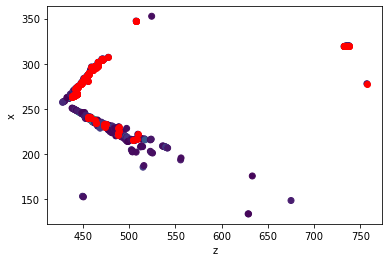

[[29, 30, 39], [31, 32, 42], [66, 67, 70], [104, 105, 113], [109, 110, 115], [177, 178, 185], [181, 182, 186], [228, 229, 236], [236, 237, 238], [339, 340, 344, 345, 347, 349, 350, 351], [340, 341, 342, 344, 345, 347, 349, 350, 351], [341, 342, 343, 344, 345, 347, 349, 350, 351], [342, 343, 344, 345, 347, 349, 350, 351], [343, 344, 345, 347, 349, 350, 351], [344, 345, 346, 347, 349, 350, 351], [345, 346, 347, 349, 350, 351], [346, 347, 349, 350, 351], [347, 348, 349], [348, 349, 350, 351], [349, 350, 351], [355, 356, 357, 358, 359, 361, 362, 364], [356, 357, 358, 359, 361, 362, 364], [357, 358, 359, 361, 362, 364], [358, 359, 360], [359, 360, 362, 363, 364], [360, 361, 362, 364], [362, 363, 364], [365, 366, 368], [366, 367, 368], [380, 381, 382], [381, 382, 385, 387, 388, 389, 390, 391, 392, 393, 395, 398, 403, 404, 405, 406, 408, 411, 418, 424], [382, 383, 385, 392], [384, 385, 389], [386, 387, 388, 389, 390, 391, 392, 393, 395, 398, 403, 404, 405, 406, 408, 411, 418, 424], [387, 388,

In [9]:
def line_collater(AoI, scale=5, wiggle=0.05, plot=True):
    AoI_z, AoI_x, AoI_adc = AoI
    L = len(AoI_z)
    
    lines = []
    ielim = np.arange(1,L)

    for i in ielim:
        line = []
        x = line_finder(AoI, i, scale, wiggle)
        
        if (x!=[]):
            line.append(x[0])
            line.append(x[1])
        while (x!=[]):
            line.append(x[-1])
            x = line_finder(AoI, x[-1], scale, wiggle, know_prev_point=True, prev_point_number=x[-2])
            
        ielim = [j for j in ielim if j not in line]
        lines.append(line)
    lines = [i for i in lines if i != []]
    if plot:
        for i in tqdm(lines):
            plt.plot([AoI_z[j] for j in i],[AoI_x[j] for j in i], 'ro')
        plotter(AoI)
        plt.show()
            
    return lines

q = line_collater(AoI, scale=10)
print(q)

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 214.09it/s]


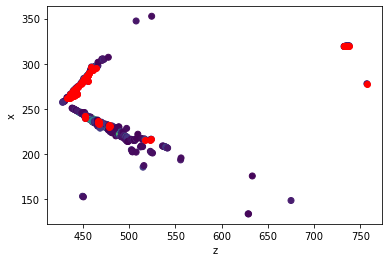

[[19, 20, 21], [81, 82, 85], [83, 84, 87], [133, 134, 136], [246, 247, 249], [334, 335, 337, 338, 341, 342, 344, 345, 347, 349, 350, 351], [345, 346, 347, 349, 350, 351], [355, 356, 357, 358, 359, 361, 362, 364], [362, 363, 364], [364, 365, 368], [373, 374, 376], [376, 377, 379, 381], [379, 380, 381, 383, 387, 388, 389, 390, 391, 392, 393, 395, 398, 403, 404, 405, 406, 408, 411], [398, 399, 400, 403, 404, 405, 406, 408, 411], [407, 408, 411], [415, 416, 419]]


In [106]:
from tqdm import tqdm

def line_collater(AoI, scale=5, wiggle=0.05, plot=True):
    AoI_z, AoI_x, AoI_adc = AoI
    L = len(AoI_z)
    
    lines = []
    ielim = np.arange(1,L)
    
    j=1
    for i in range(1,L):
        j+=1
        if j==L:
            break
        line = []
        x = line_finder(AoI, j, scale, wiggle)
        
        if (x!=[]):
            
            line.append(x[0])
            line.append(x[1])
        while (x!=[]):
            j+=1
            line.append(x[-1])
            x = line_finder(AoI, x[-1], scale, wiggle, know_prev_point=True, prev_point_number=x[-2])

        lines.append(line)
    lines = [i for i in lines if i != []]
    if plot:
        for i in tqdm(lines):
            plt.plot([AoI_z[j] for j in i],[AoI_x[j] for j in i], 'ro')
        plotter(AoI)
        plt.show()
            
    return lines

q = line_collater(AoI)
print(q)

In [ ]:
def line_ploter(AoI, scale, wiggle):
    lines = line_collater(AoI, scale, wiggle)

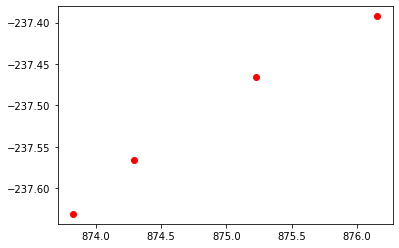

In [8]:
AoI_z, AoI_x, AoI_adc = AoI
for i in x:
    plt.plot(AoI_z[i],AoI_x[i], 'ro')
#plotter(AoI)
plt.show()